In [80]:
import numpy as np
import sounddevice as sd
import datetime
from scipy.signal import butter, lfilter
from scipy.io import wavfile

def generate_white_noise(duration, sample_rate):
    """
    generate white noise
    to make experiments reproducible, set a seed
    """
    np.random.seed(42)
    white_noise = np.random.randn(int(sample_rate * duration))
    return white_noise

def band_limited_white_noise(low, high, duration, sample_rate):
    """Apply a butterworth filter"""
    white_noise = generate_white_noise(duration, sample_rate)
    nyq = 0.5 * sample_rate
    low = low / nyq
    high = high / nyq
    b, a = butter(5, [low, high], btype='band')
    band_limited = lfilter(b, a, white_noise)
    return band_limited

def pseudo_white_noise(low, high, repetitions, duration, sample_rate):
    """Generate pseudoNoise"""
    # use sinusoidal signal with random phase as pseudo noise
    # t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    # pseudo_noise = np.sin(2 * np.pi * 20 * t + np.random.uniform(0, 2 * np.pi))
    band_limited_noise = band_limited_white_noise(low, high, duration/repetitions)
    pseudo_noise = np.tile(band_limited_noise, repetitions)
    # store the sound signal
    # Format the date and time
    filename = f"pseudoNoise_{low}_{high}.wav"
    wavfile.write(filename, sample_rate, pseudo_noise)
    return pseudo_noise

import numpy as np
import sounddevice as sd

def play_sound(sound, channel, sample_rate):
    """Play the sound on a specified channel (0 or 1)"""
    if sound.ndim == 1:
        # If the sound is mono, duplicate it for both channels
        sound = np.tile(sound[:, np.newaxis], (1, 2))
    
    # Create a stereo sound array with one channel set to zero
    stereo_sound = np.zeros_like(sound)
    
    if channel == 0:
        # Play on left channel
        stereo_sound[:, 0] = sound[:, 0]
    elif channel == 1:
        # Play on right channel
        stereo_sound[:, 1] = sound[:, 1]
    else:
        raise ValueError("Channel must be 0 or 1")
    
    sd.play(stereo_sound, samplerate=sample_rate)
    sd.wait()


In [5]:
# this block setup the plotter default aspect ratio and font size

import matplotlib.pyplot as plt
import seaborn as sns

w = 12 / 1.1
h = w * (3 / 10)
ASPECT = (w, h)  # w, h in inches

font_size = 12

# Enable LaTeX rendering + set font size
plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.size": font_size,
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.titlesize": font_size,
    }
)

In [4]:
# this block is for testing, allowd to reload the module soundfieldanalysis
%load_ext autoreload
%aimport bf3d_prep
%autoreload 1
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
bf3d_prep

Modules to skip:



In [5]:

# select the file
import numpy as np
from bf3d_prep import bf3d_data_prep

eq_prep = bf3d_data_prep(rootfolder = 'Recordings/HATS_recordings', filetype = '.npz')


Dropdown(description='Select:', options=('..', 'equalizer_HP1.npz'), value='..')

Button(description='Select', style=ButtonStyle())

Output()

In [6]:
# read the .npz file
# load the filter and the reference level
equalizer = np.load('Recordings/HATS_recordings/equalizer_HP1.npz')
filter = equalizer['filter']
ref_level = equalizer['ref_level']

# The ref_level is used to equalize the sound level output from mutiple 
# headphones. so to get it work, we compare different headphones ref_level, and then find the 
# lowest one, and then use this lowest one as the standard ref_level, then make the rest with
# certain decaying in decibel, to make them equalize

filter_freq = equalizer['frequency']

taps = equalizer['taps']

sample_rate = equalizer['sample_rate']

In [10]:

# generate and play white noise
# for i in np.arange(10):
duration = 40 # 10s
band_limited_noise = band_limited_white_noise(20, 14000, duration, sample_rate)

# apply the taps with filtfilt
from scipy.signal import filtfilt, lfilter
eq_noise = filtfilt(taps, 1, band_limited_noise)
# eq_noise = np.sign(eq_noise) * np.sqrt(np.abs(eq_noise))


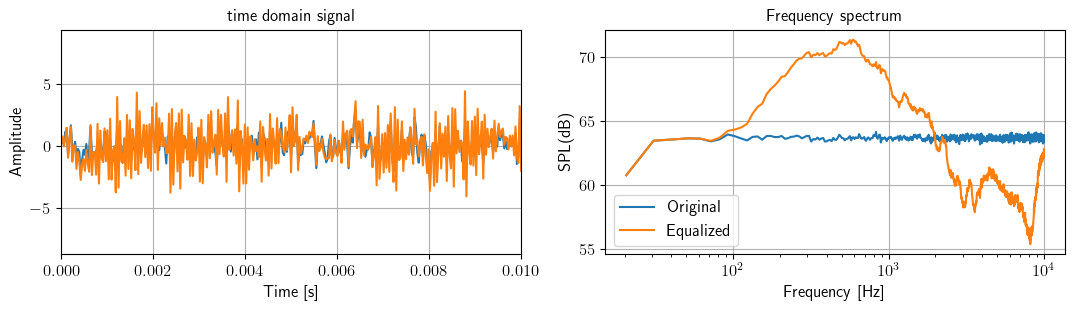

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# parameters：
time_signal = np.arange(0, duration, 1/sample_rate)
data_signal_eq = eq_noise
data_signal = band_limited_noise

# FFT
frequencies, fft_result = welch(data_signal, fs=sample_rate, scaling='spectrum', nperseg=3200, return_onesided=True)
frequencies, fft_result_eq = welch(data_signal_eq, fs=sample_rate, scaling='spectrum', nperseg=3200, return_onesided=True)
fft_result = np.sqrt(fft_result)
fft_result_eq = np.sqrt(fft_result_eq)
# choose the frequency range of fft analysis from 20Hz to 10kHz
min_freq = 20
max_freq = 10000
mask = (frequencies >= min_freq) & (frequencies <= max_freq)

plt.figure(figsize=ASPECT)
plt.subplot(1, 2, 1)
plt.plot(time_signal, data_signal, label='Original')
plt.plot(time_signal, data_signal_eq, label='Equalized')
plt.title('time domain signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim([0, 0.01])
plt.grid()

plt.subplot(1, 2, 2)
plt.semilogx(frequencies[mask],20*np.log10(np.abs(fft_result[mask])/20e-6), label='Original')
plt.semilogx(frequencies[mask],20*np.log10(np.abs(fft_result_eq[mask])/20e-6), label='Equalized')
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
# make the legend location be outside the plot upper right
plt.legend(loc='lower left')
plt.tight_layout()
plt.grid()
plt.show()


In [13]:
# play the sound
play_sound(eq_noise, 0, sample_rate=sample_rate) # channel 0 cooresponds to the left ear
                        # channel 1 cooresponds to the 
                        # right ear

In [56]:
# play the sound
play_sound(band_limited_noise, 0, sample_rate=sample_rate) # channel 0 cooresponds to the left ear
                        # channel 1 cooresponds to the right ear

In [1]:
%load_ext autoreload
%aimport bf3d_prep
%autoreload 1
%aimport

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Modules to reload:
bf3d_prep

Modules to skip:



In [2]:
# from this block is for the HATs recording
# it will import the .wav file

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.io import wavfile

# select the file
from bf3d_prep import bf3d_data_prep
import numpy as np

recording_prep = bf3d_data_prep(rootfolder = 'Recordings/HATS_recordings', filetype = '.wav')

Dropdown(description='Select:', options=('..', 'HP1-12.8kHz-leftear.wav', 'HP1-eqed-leftear-fir.wav', 'HP1-eqe…

Button(description='Select', style=ButtonStyle())

Output()

C:\Users\ZHLI\AppData\Local\Temp\ipykernel_20920\1474734597.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, hats_t = wavfile.read(recording_prep.selected_file)


The peak value is 86.47196146222406 dB SPL


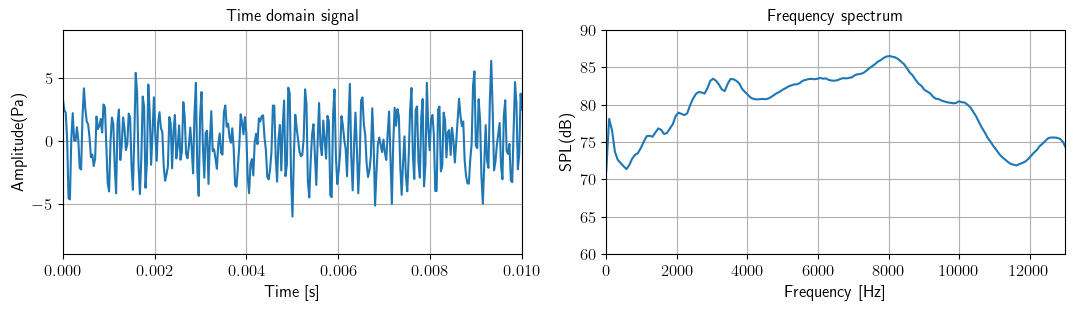

In [13]:
# read the wav file
# get the frequency response by welch method
# 94 dB re 20uPa

sample_rate, hats_t = wavfile.read(recording_prep.selected_file)

#sample_rate = 44100
# hats_t = sin_signal
# the raw wav datas should be converted to pa
# the factor 32767 is the maximum value of the 16-bit integer
# hats_t = hats_t / (2**32/2-1)* 10

time_signal = np.arange(0, len(hats_t)/sample_rate, 1/sample_rate)
data_signal = hats_t / (2**32/2-1)* 10

# FFT
frequencies, fft_result = welch(data_signal, fs=sample_rate, scaling='spectrum', nperseg=400, return_onesided=True)

# The fft_result is the rms
# fft_result = np.sqrt(2) * fft_result
fft_result = np.sqrt( fft_result )

plt.figure(figsize=ASPECT)
plt.subplot(121)
plt.plot(time_signal, data_signal)
plt.xlim([0, 0.01])
plt.title('Time domain signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude(Pa)')
plt.grid()


plt.subplot(122)
plt.plot(frequencies,20*np.log10(np.abs(fft_result)/20e-6))
plt.xlim([0, 13000])
plt.ylim([60, 90])
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.tight_layout()
plt.grid()
# get the peak value
peak_value = np.max(20*np.log10(np.abs(fft_result)/20e-6))
print(f"The peak value is {peak_value} dB SPL")
plt.show()



Caption:
Time and frequency response from the headphone to an artificial ear microphone, using a white band noise stimulus band-limited from 20 Hz to 14 kHz. 

Text:
The frequency spectrum was obtained through Welch's method for short-time averaged spectral analysis, employing FFT with a default Hanning window. Each segment consists of 400 FFT bins.



max value:  1813700992
32bit float max value:  21474836470.0
max value in pa:  8.445703391193275


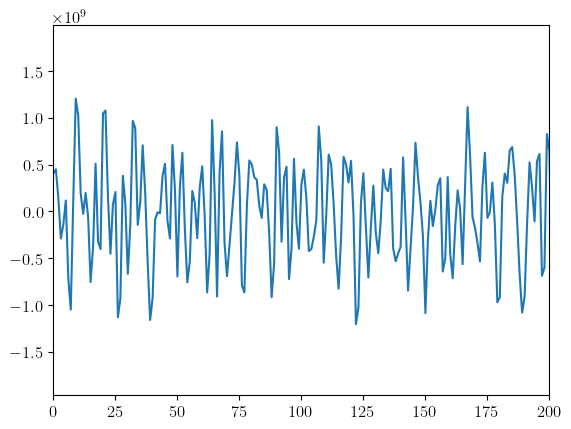

In [22]:
plt.plot(hats_t)
plt.xlim([0,200])
print("max value: ", np.max(hats_t, axis=0))
print("32bit float max value: ", (2**32/2-1)* 10)
print("max value in pa: ", np.max(hats_t, axis=0)/(2**32/2-1)* 10)

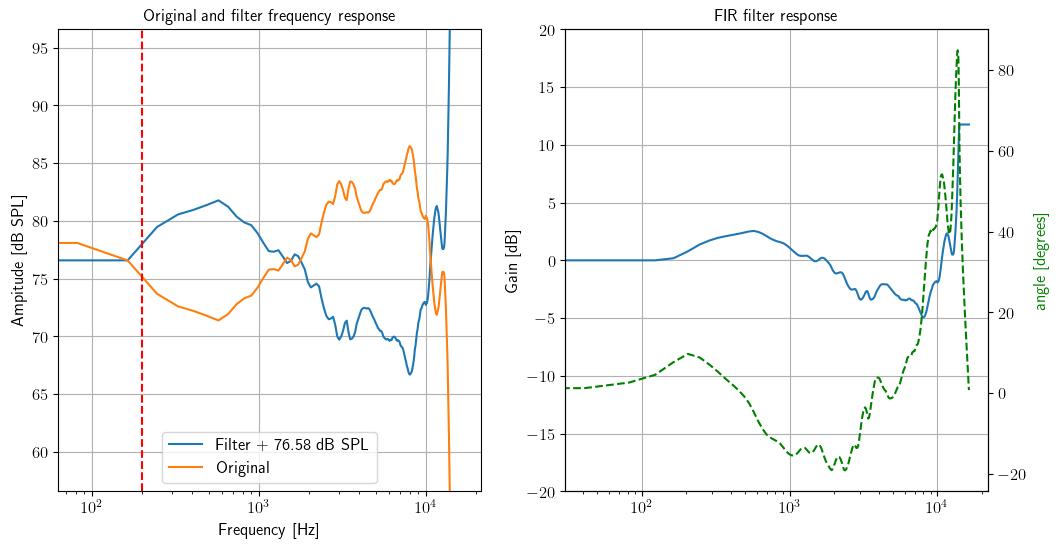

In [86]:
from scipy.signal import firwin2, lfilter, minimum_phase


# based on the spectrum I get, revert it, then get a filter
# the filter is used to filter the original signal

# select the low frequency, set it as a reference
low_freq = 200

# select the high frequency, set all the values above it to be 10
# the original stimulus upper limit is 12000 Hz
# high_freq = 10000

# get the index of the low frequency
low_freq_index = np.argmin(np.abs(frequencies - low_freq))
# get the index of the high frequency
# high_freq_index = np.where(frequencies >= high_freq)[0][0]

# set a reference level, to make different equipment comparable
# all equipment should have the same reference level
ref_level = fft_result[low_freq_index]

# scale the fft_result, where the low frequency is the reference, should be 0 dB
fft_result_rec = fft_result / ref_level

# make all the values below the low frequency to be 1
fft_result_rec[:low_freq_index] = 1

# revert the fft_result
fft_result_rec = 1/(fft_result_rec)

fft_result_rec[fft_result_rec > 15] = 15

filter_rec = np.real(fft_result_rec)

# calculate the reference level in dB, only take 3 digits
ref_level_db = 20 * np.log10(ref_level / 20e-6).round(3)


# plot the filter
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(frequencies, 20*np.log10(filter_rec) + ref_level_db, label=f'Filter + {ref_level_db} dB SPL')
plt.semilogx(frequencies, 20*np.log10(fft_result/20e-6), label='Original')
plt.axvline(x=low_freq, color='r', linestyle='--')
plt.title('Original and filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Ampitude [dB SPL]')
plt.grid()
plt.ylim(ref_level_db - 20, ref_level_db + 20)
plt.legend()

fs = sample_rate

fir_filt = firwin2(1023, frequencies, filter_rec, fs = sample_rate, antisymmetric=False)
fir_filt = minimum_phase(fir_filt)

ax1 = plt.subplot(1, 2, 2)
from scipy.signal import freqz

w, h = freqz(fir_filt, worN=400, fs = sample_rate)
# draw a line at the low frequency
plt.title('FIR filter response')
plt.semilogx(w, 20 * np.log10((h)))
plt.ylabel('Gain [dB]')
plt.ylim([-20, 20])
plt.grid()

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
# get angle in degrees
angles = np.degrees(angles)
plt.plot(w, angles, 'g', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('angle [degrees]', color='g')
plt.show()


Caption:
The left plot is the frequency response of the filter and the original signal. The Filter is reverted at the red dashed line. The right plot is the frequency response of the FIR filter, which is obtained from the frequency response of the filter shape. The green dashed line is the phase response of the FIR filter. 

The way to obtain the FIR filter response is the minimum phase, which means it's the squre root of the FIR H, so when apply this filter we use the filtfilt method - the forward and reverse method to get the reponse without additional phase added onto the origional signal.

So, the origional white noise were filtered by this obtained FIR filter. To get the equalized stimuli. By this method, we can equalize the output from all measured headphones, so different headphone's sound leakage will become compareable.


the length of the convolved data is 517506


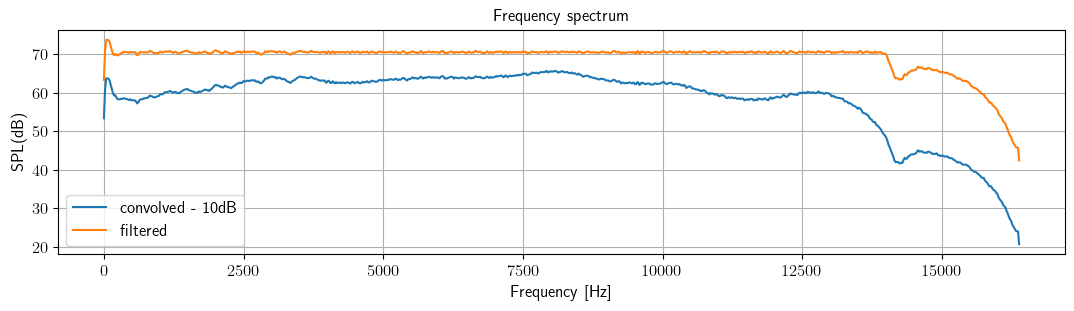

In [87]:
conv_data = np.convolve(data_signal, fir_filt, mode="full")

filt_data = filtfilt(fir_filt, 1, data_signal)
print(f"the length of the convolved data is {len(conv_data)}")

# FFT
conv_freq, conv_fft = welch(conv_data, fs=sample_rate, scaling='spectrum', nperseg=1600, return_onesided=True)
filt_freq, filt_fft = welch(filt_data, fs=sample_rate, scaling='spectrum', nperseg=1600, return_onesided=True)

# The fft_result is the rms
# fft_result = np.sqrt(2) * fft_result
conv_fft = np.sqrt(conv_fft)
filt_fft = np.sqrt(filt_fft)

plt.figure(figsize=ASPECT)
plt.plot(conv_freq,20*np.log10(np.abs(conv_fft)/20e-6)-10, label = 'convolved - 10dB')
plt.plot(filt_freq,20*np.log10(np.abs(filt_fft)/20e-6), label = 'filtered')
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.legend()
plt.tight_layout()
plt.grid()

In [85]:
filt_noise = filtfilt(fir_filt, 1, band_limited_noise)
conv_noise = np.convolve(band_limited_noise, fir_filt, mode="full")


In [81]:
play_sound(sound = filt_noise, channel=0, sample_rate=sample_rate)

In [42]:
# save the equalizer, and the reference level into a file
# the file is used to equalize the original signal
# for different equipment, the reference level will be taken to make a same level output

# save the filter and the reference level
np.savez(f'Recordings/HATS_recordings/equalizer_HP1.npz',
          filter=filter, 
         ref_level=ref_level, 
         frequency=frequencies, 
         taps = taps, 
         sample_rate = sample_rate)


In [ ]:
# import the filter

In [ ]:


# save the filter as a .wav file
# the filter is the inverse of the spectrum
# the filter is used to filter the original signal
# the filter is used to make the original signal to be flat

from scipy.signal import firwin, lfilter
from scipy.io import wavfile

filter = np.abs(fft_result_rec)


In [20]:
# apply the filter to the white noise
# the filter is the fft_result_rec

# get the time domain signal
time_signal = np.arange(0, duration, 1/sample_rate)
# get the original white noise
white_noise = band_limited_white_noise(20, 16000, duration)

# interpolate the fft_result_rec to make it match the length of the white noise
fft_result_rec = np.interp(np.arange(len(white_noise)), np.arange(len(fft_result_rec)), fft_result_rec)

# get the filtered white noise
filtered_white_noise = np.fft.irfft(np.fft.rfft(white_noise) * fft_result_rec)

# play the filtered white noise
play_sound(sound = filtered_white_noise, channel=0)

# plot the time domain signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_signal, white_noise)
plt.title('Original white noise')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time_signal, filtered_white_noise)
plt.title('Filtered white noise')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (661501,) (1323000,) 